In [1]:
import pandas as pd
import networkx as nx
import argparse
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns; sns.set()

### Creating DataFrame

In [2]:
with open("author_year_sub.csv", "rb") as fp:   # Unpickling
    df = pickle.load(fp)

In [9]:
df.head()

,Author,year,subreddit
0,gege33,2012,MGTOW
2,Obsidian_Order,2012,MGTOW
3,Obsidian_Order,2012,MGTOW
4,MaunaLoona,2012,MGTOW
5,AnnArchist,2012,MGTOW


In [8]:
df = df.astype({"year": int})

In [6]:
MR_subreddits = ['LadyMRAs', 'FeMRADebates', 'Masculism', 'MensRants', 'FeMRA', 'MRActivism',
                 'MensRightsLaw', 'MRRef']  # removed againstmansrights

Incel_subreddits = ['askanincel', 'BlackPillScience', 'IncelsWithoutHate', 'Braincels']

MGTOW_subreddits = ['MGTOW']

RedPill_subreddits = ['RedPillParenting', 'TRPOffTopic', 'GEOTRP', 'thankTRP', 'redpillbooks',
                      'becomeaman', 'RedPillWomen', 'TheBluePill', 'asktrp', 'TheRedPill']  # removed exredpill

In [ ]:
MGTOW_df = df[df.subreddit == 'MGTOW']
MGTOW_df['year'] = MGTOW_df['year'].mask(MGTOW_df['year'] < 2015)
MGTOW_df['year'] = MGTOW_df['year'].fillna(2014)
MGTOW_df = MGTOW_df.astype({"year": int})

In [ ]:
RedPill_df = df.loc[df['subreddit'].isin(RedPill_subreddits)]
RedPill_df['year'] = RedPill_df['year'].mask(RedPill_df['year'] < 2015)
RedPill_df['year'] = RedPill_df['year'].fillna(2014)
RedPill_df = RedPill_df.astype({"year": int})

In [ ]:
MR_df = df.loc[df['subreddit'].isin(MR_subreddits)]
MR_df['year'] = MR_df['year'].mask(MR_df['year'] < 2015)
MR_df['year'] = MR_df['year'].fillna(2014)
MR_df = MR_df.astype({"year": int})

In [ ]:
Incel_df = df.loc[df['subreddit'].isin(Incel_subreddits)]
Incel_df['year'] = Incel_df['year'].mask(Incel_df['year'] < 2015)
Incel_df['year'] = Incel_df['year'].fillna(2014)
Incel_df = Incel_df.astype({"year": int})

In [33]:
RedPill_df['community'] = 'RP'
MR_df['community'] = 'MR'
MGTOW_df['community'] = 'MGTOW'
Incel_df['community'] = 'Incel'
community_df = MR_df
community_df = community_df.append(RedPill_df, ignore_index=True)
community_df = community_df.append(MGTOW_df, ignore_index=True)
community_df = community_df.append(Incel_df, ignore_index=True)

In [36]:
community_df.to_pickle('author_year_sub.csv')

### Jaccard Similarity

In [207]:
df.tail()

,Author,year,subreddit,community
10579822,LeninistSkynet,2019,IncelsWithoutHate,Incel
10579823,plamplamthrow0321,2019,IncelsWithoutHate,Incel
10579824,DiscombobulatedWait3,2019,IncelsWithoutHate,Incel
10579825,CREEPYFUCKBOI,2019,IncelsWithoutHate,Incel
10579826,thelambofdeth,2019,IncelsWithoutHate,Incel


In [67]:
time = [2014, 2015, 2016, 2017, 2018, 2019]

In [68]:
def jaccard(df1, df2):

    sub1 = df1["Author"].drop_duplicates()
    sub2 = df2["Author"].drop_duplicates()
    
    inter = len(sub1[sub1.isin(sub2)])
    AUB = len(sub1) + len(sub2) - inter
    
    if AUB == 0:
        return 1
    
    return inter / AUB

### Intersection Matrices

In [69]:
sub_dfs = [df[df.community == 'MR'], df[df.community == 'RP'],
           df[df.community == 'MGTOW'], df[df.community == 'Incel']]

In [70]:
matrices = []
for i in range(len(time)):
    matrices.append(np.zeros((4, 4)))

In [71]:
for year in range(len(time)):
    for row in range(4):
        for col in range(4):
            matrices[year][row, col] = jaccard(sub_dfs[row].loc[sub_dfs[row].year==time[year]],
                                               sub_dfs[col].loc[sub_dfs[col].year==time[year]])

In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [117]:
communities = ['MR', 'RP', 'MGTOW', 'Incel']

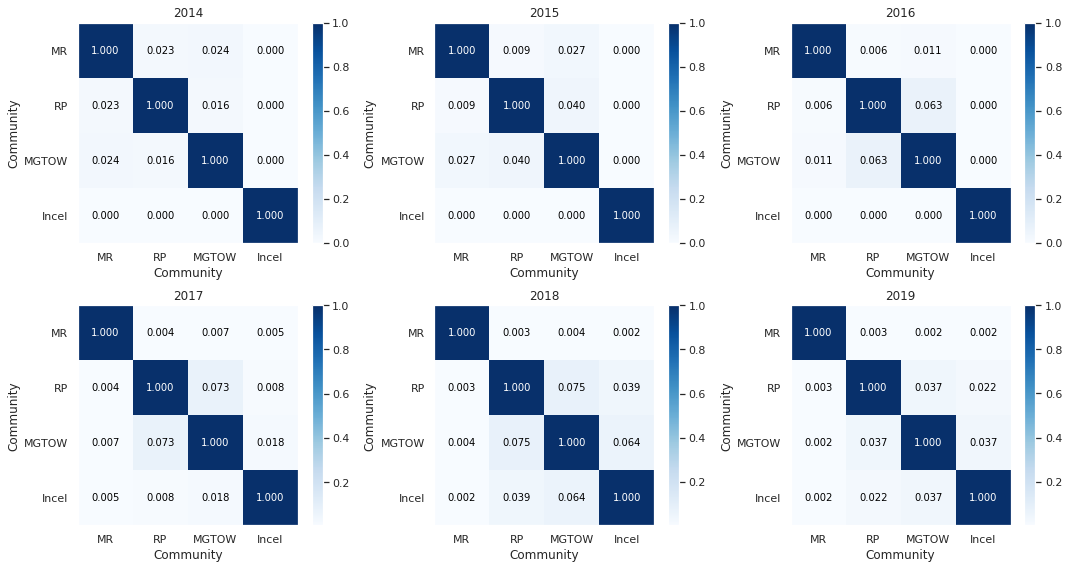

In [82]:
nr_rows = 2
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*5,nr_rows*4), squeeze=False)


for r in range(0,nr_rows):
    for c in range(0, nr_cols): 
        col = r*nr_cols+c
        
        if col < len(matrices):
            
            matrix = matrices[col]
            title = time[col]
            cmap=plt.cm.Blues
            
            axs[r][c].grid(False)
            im = axs[r][c].imshow(matrix, interpolation='nearest', cmap=cmap)
            axs[r][c].figure.colorbar(im, ax=axs[r][c])

            # We want to show all ticks...
            axs[r][c].set(xticks=np.arange(matrix.shape[1]),
                   yticks=np.arange(matrix.shape[0]),
                   # ... and label them with the respective list entries
                   xticklabels=communities, yticklabels=communities,
                   title=title,
                   ylabel='Community',
                   xlabel='Community')

            # Loop over data dimensions and create text annotations.
            fmt = '.3f'
            thresh = matrix.max() / 2.
            for i in range(matrix.shape[0]):
                for j in range(matrix.shape[1]):
                    axs[r][c].text(j, i, format(matrix[i, j], fmt),
                            ha="center", va="center",
                            color="white" if matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.savefig('Inter_Matrix_by_year.png')
plt.show()

* Show the # of authors of each community can be a good way to measure the relevance of that similarity

### Graph Using Jaccard Similarity 

In [179]:
G = nx.Graph()

In [180]:
G.add_nodes_from(communities)

In [216]:
edges = itertools.combinations(communities, 2)

In [182]:
G.add_edges_from(edges) 

In [183]:
for i in itertools.combinations(communities, 2):
    print(i)

('MR', 'RP')
('MR', 'MGTOW')
('MR', 'Incel')
('RP', 'MGTOW')
('RP', 'Incel')
('MGTOW', 'Incel')


In [202]:
for i in itertools.combinations(communities, 2):
    G.edges[i[0], i[1]]['weight'] = jaccard(df[df.community == i[0]], df[df.community == i[1]])
    print(f'{i[0]}\t{i[1]}\t{jaccard(df[df.community == i[0]], df[df.community == i[1]])}')

MR	RP	0.012090292822699
MR	MGTOW	0.01078032329340621
MR	Incel	0.004621216868224826
RP	MGTOW	0.07586506062106467
RP	Incel	0.027781366505481526
MGTOW	Incel	0.06284024779425568


In [239]:
for i in G.edges:
    print(G.edges[i]['weight'])

0.012090292822699
0.01078032329340621
0.004621216868224826
0.07586506062106467
0.027781366505481526
0.06284024779425568


* Jaccard similarity is multiplied by 1000 to improve Fruchterman-Reingold force-directed algorithm.

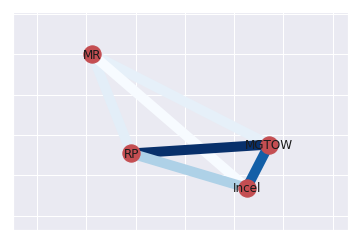

In [253]:
size = [G.edges[i]['weight'] for i in G.edges]
nx.draw_networkx(Gr, pos=nx.spring_layout(Gr, seed=6, scale=0.1), with_labels=True,
                 edge_color=np.array(size), width=10, edge_cmap=plt.cm.Blues, node_color='r')

In [186]:
G.edges['MR', 'MGTOW']['weight']

0.01078032329340621

In [218]:
Gr.add_edges_from(edges) 
Gr.edges

EdgeView([('MR', 'RP'), ('MR', 'MGTOW'), ('MR', 'Incel'), ('RP', 'MGTOW'), ('RP', 'Incel'), ('MGTOW', 'Incel')])

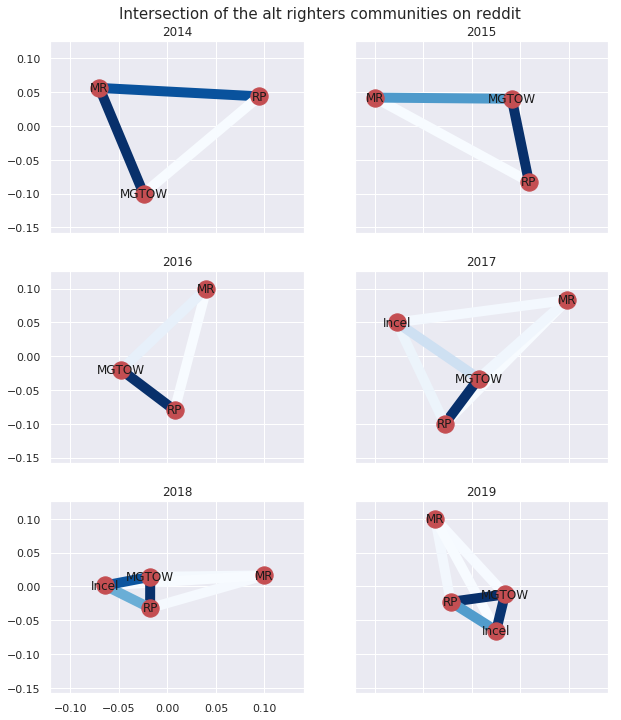

In [256]:
Graphs = []
nr_rows = 3
nr_cols = 2

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*5,nr_rows*4), squeeze=False, sharex=True, sharey=True)
fig.suptitle('Intersection of the alt righters communities on reddit', fontsize=15, y=0.92)

for r in range(0, nr_rows):
    for c in range(0, nr_cols): 
        col = r*nr_cols+c
        Gr = nx.Graph()
        Gr.add_nodes_from(communities)
        Gr.add_edges_from(itertools.combinations(communities, 2)) 
        
        for i in itertools.combinations(communities, 2):
            df1 = df[df.community == i[0]]
            df2 = df[df.community == i[1]]
            Gr.edges[i[0], i[1]]['weight'] = 10000 * jaccard(df1.loc[df1.year==time[col]],
                                                             df2.loc[df2.year==time[col]])
        
        no_degree = []
        size = []
        
        for node in Gr.nodes:
            if Gr.degree(node, weight='weight') == 0:
                no_degree.append(node)
            else:
                size.append(Gr.degree(node, weight='weight'))
    
        Gr.remove_nodes_from(no_degree)
        
        axs[r, c].set_title(time[col])
        
        size = [Gr.edges[i]['weight'] for i in Gr.edges]
        nx.draw_networkx(Gr, pos=nx.spring_layout(Gr, seed=6, scale=0.1), with_labels=True,
                         edge_color=np.array(size), width=10, edge_cmap=plt.cm.Blues,
                         node_color='r', ax=axs[r, c])